In [25]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

Get Data & Compute % Change

In [26]:
tr_elha = pd.read_parquet(r'C:\Users\vnsp8460\Desktop\Johnny_folder\policy_change\Data\new_policy_change_skus_21_07_2025.parquet')

In [27]:
# Create custom ADO column
tr_elha['ado_march'] = tr_elha['total_orders_march'] / 30
tr_elha['ado_april'] = tr_elha['total_orders_april'] / 30

def convert_to_float(df, *cols):
    for col in cols:
        df[col + '_april'] = df[col + '_april'].astype(float)
        df[col + '_march'] = df[col + '_march'].astype(float)

    return df

tr_elha = convert_to_float(tr_elha, 'cogs', 'ado', 'gmv', 'take_rate')

In [28]:
# Compute % Change for relevant columns
def compute_percent_change(df, *cols):
    """
    Computes percent change for specified column prefixes.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        *cols (str): Column name prefixes (e.g., 'cogs', 'take_rate') to compute percent change for.
        
    Adds new columns in the format: <col>_change
    """
    for col in cols:
        # Avoid division by zero
        march_cols = [col + '_march' for col in cols]
        df = df[(df[march_cols] != 0).all(axis=1)].copy()

        # Compute percent change
        df[col + '_change'] = ((df[col + '_april'] / df[col + '_march']) - 1) * 100

    return df

tr_elha = compute_percent_change(tr_elha, 'take_rate', 'cogs', 'ado')

In [29]:
# Select all columns that do not end with '_april'
tr_elha_march = tr_elha.loc[:, ~tr_elha.columns.str.endswith('_april')].copy()

In [30]:
# Remove outliers
cols = [
    'cogs_change', 'ado_change', 
    'cogs_march', 'ado_march', 
    'take_rate_march', 'gmv_march',
    'take_rate_change'
]
for col in cols:
    lower, upper = tr_elha[col].quantile([0.01, 0.99])
    tr_elha_march = tr_elha_march[(tr_elha_march[col]>lower) & (tr_elha_march[col]<upper)]

In [31]:
# Label treatment group
treatment_threshold = 5 
tr_elha_march["treatment"] = tr_elha_march["take_rate_change"].apply(lambda x: 1 if x >= treatment_threshold else 0)

In [32]:
# cogs_change_label
lower, upper = tr_elha_march['cogs_change'].quantile([0.25,0.75])
def label_cogs_change(x):
    if x>=upper:
        return 'high'
    if x<=lower:
        return 'low'
    else:
        return 'mid'
    
tr_elha_march['cogs_change_label'] = tr_elha_march['cogs_change'].apply(label_cogs_change)

In [ ]:
# Remove cogs_change = 0 (Optional)
def cogs_change0(df, remove=False):
    if remove==True:
        df = df[df['cogs_change']!=0]
    return df

tr_elha_march = cogs_change0(tr_elha_march, remove=False) 

XGBoost (SKU Level, Seller Side)

In [34]:
# Selected features
selected_features = [
    'seller_type',
    #'is_new_join',
    #'take_rate_march',
    'gmv_march',
    'cogs_march',
    'ado_march',
    'model_clicks_march',
    'model_impressions_march',
    'ads_clicks_march',
    'ads_impressions_march',
    'ads_spend_march',
    #'model_create_month',
    'active_months',
    'level1_global_be_category',
    'level2_global_be_category'
]

# Predict treatment
X = tr_elha_march[selected_features]
y = tr_elha_march["treatment"]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=52
)

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Define categorical and continuous columns
categorical_cols = ['seller_type', 'level1_global_be_category', 'level2_global_be_category']
continuous_cols = [col for col in selected_features if col not in categorical_cols]

processor = ColumnTransformer(
    transformers=[
        ("numerical", MinMaxScaler(), continuous_cols),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
    ],
    verbose_feature_names_out=False,
    remainder="drop"
)

# XGBoost classifier
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=52,
    n_jobs=-1,
)

e2e_pipeline = Pipeline(steps=[
    ("preprocess", processor),
    ("modeling", model)
])

# Fit model
e2e_pipeline.fit(X_train, y_train)

# Predict and evaluate
train_preds = e2e_pipeline.predict_proba(X_train)[:, 1]
holdout_preds = e2e_pipeline.predict_proba(X_holdout)[:, 1]

# Print AUC
print("Train AUC:", roc_auc_score(y_train, train_preds))
print("Holdout AUC:", roc_auc_score(y_holdout, holdout_preds))

# Assign a propensity score to each model
propensity_score = e2e_pipeline.predict_proba(X)[:,1]
tr_elha_march['propensity_score'] = propensity_score

c:\Users\vnsp8460\Desktop\Johnny_folder\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train AUC: 0.8376703326383329
Holdout AUC: 0.8362678884433923


c:\Users\vnsp8460\Desktop\Johnny_folder\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [35]:
def generate_bins(df, col):
    vals = df[col].dropna()
    val_min = vals.min() - 0.01
    val_max = vals.max()
    step_pct = 0.15
    step_abs = (val_max-val_min)/10

    bin_edges = [val_min]
    while bin_edges[-1] < val_max:
        next_edge = max(bin_edges[-1] + step_abs, bin_edges[-1] * (1+step_pct)) 
        bin_edges.append(next_edge)

    bin_edges = np.round(bin_edges, 2)

    bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

    new_col = col + "_bin"

    df[new_col] = pd.cut(
        df[col],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True
    )

generate_bins(tr_elha_march, 'ado_march')
generate_bins(tr_elha_march, 'gmv_march')

In [36]:
# Max value for delta
print(np.std(np.log(tr_elha_march['propensity_score']/(1-tr_elha_march['propensity_score']))) * 0.2)

0.26217765


In [37]:
def get_comparable_pairs(df, delta=0.1, with_replacement=False):
    treatment_control_pairs = []
    group_cols = [
        #"function_detail",
        #"main_cat",
        #"ado_segment_group",
        #"penalty_point_group",
        # "abs_segment_group",
        # "video_ado_segment",
        # "livestream_ado_segment",
        'gmv_march_bin',
        'ado_march_bin',
        'is_new_join'
    ]

    grouped = df.groupby(group_cols)

    for group_keys, group_df in grouped:
        treatment_df = group_df[group_df["treatment"] == 1].sort_values(
            by="propensity_score", ascending=True
        )
        control_df = group_df[group_df["treatment"] == 0].sort_values(
            by="propensity_score", ascending=True
        )

        treatment_ids = treatment_df["model_id"].values
        treatment_scores = treatment_df["propensity_score"].values
        control_ids = control_df["model_id"].values
        control_scores = control_df["propensity_score"].values
        # ####
        # treatment_other = treatment_df["adgmv_quarter"].values
        # control_other = control_df["adgmv_quarter"].values
        # ####
        control_idx = 0
        for treatment_idx in range(treatment_scores.shape[0]):
            cur_treatment_prop = treatment_scores[treatment_idx]
            # ####
            # cur_treatment_other = treatment_other[trea
            # ####
            while (
                control_idx <= control_scores.shape[0] - 1
                and abs(cur_treatment_prop - control_scores[control_idx]) > delta
            ):
                control_idx += 1
            valid_control_id = (
                None
                if control_idx > control_scores.shape[0] - 1
                else control_ids[control_idx]
            )
            treatment_control_pairs.append(
                [treatment_ids[treatment_idx], valid_control_id]
            )
            if valid_control_id is not None and not with_replacement:
                control_idx += 1

    return {"TC_pairs": treatment_control_pairs}

pairings = get_comparable_pairs(tr_elha_march, with_replacement=True)

C:\Users\vnsp8460\AppData\Local\Temp\ipykernel_19164\900251038.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols)


In [38]:
def generate_paired_stats(pairings, df, pair_col="TC_pairs"):
    """
    Generate a dataframe combining treatment and control model statistics,
    and compute differences in key metrics.

    Returns:
    - paired_stats: merged treatment + control info
    - treatment_id: list of treatment model_ids
    - control_id: list of control model_ids
    - treatment_df: subset of df with treatment models
    - control_df: subset of df with control models
    """
    # Get treatment and control model_ids
    tc_pairs = np.array(pairings[pair_col])
    treatment_id = tc_pairs[:, 0]
    control_id = tc_pairs[:, 1]

    # Matched pair structure
    matched_data = pd.DataFrame({
        "treatment_model_id": treatment_id,
        "selected_control_model_id": control_id
    })

    # Filter original df
    treatment_df = df[df["model_id"].isin(treatment_id)].copy()
    control_df = df[df["model_id"].isin(control_id)].copy()

    # Merge treatment info
    treatment_stats = matched_data.merge(
        df, left_on='treatment_model_id', right_on='model_id', how='left', suffixes=('', '_treatment')
    )
    treatment_stats = treatment_stats[~pd.isna(treatment_stats["selected_control_model_id"])]

    # Merge control info
    paired_stats = treatment_stats.merge(
        df, left_on='selected_control_model_id', right_on='model_id', how='left', suffixes=('_treatment', '_control')
    )

    # Compute sensitivity diffs
    key_metrics = ['cogs_change', 'take_rate_change']
    for metric in key_metrics:
        paired_stats[f"{metric}_diff"] = paired_stats[f"{metric}_treatment"] - paired_stats[f"{metric}_control"]

    return paired_stats, treatment_id, control_id, treatment_df, control_df

paired_stats, treatment_id, control_id, treatment_df, control_df = generate_paired_stats(pairings, tr_elha_march)

#paired_stats2 = paired_stats.copy()

In [39]:
def percent_unmatched(treatment, control):
    unmatched_treatment = treatment[pd.isna(control)]
    percent = len(unmatched_treatment)/len(treatment)*100
    percent_rounded = round(percent, 4) 
    return percent_rounded

print(f"Percent of unmatched treatment_ids: {percent_unmatched(treatment_id, control_id)}%")

Percent of unmatched treatment_ids: 6.2061%


In [40]:
def matching_check(df, treatment, control):
    i = random.randint(0, len(treatment) - 1)
    return df[(df['model_id']==treatment[i]) | (df['model_id']==control[i])][[
        'model_id','treatment','seller_type','is_new_join','ado_march_bin','gmv_march_bin','propensity_score'
    ]].sort_values(by='treatment')

matching_check(tr_elha_march, treatment_id, control_id)

,model_id,treatment,seller_type,is_new_join,ado_march_bin,gmv_march_bin,propensity_score
1957276,157350050694,0,Local,New Join,0.06–0.46,0.27–134.45,0.302751
1201778,256889896482,1,CB,New Join,0.06–0.46,0.27–134.45,0.399691


In [41]:
def compute_smd_two_groups(df_treatment, df_control, selected_features):
    """
    Compute standardized mean differences (SMD) between two groups given as separate DataFrames.

    Parameters:
    - df_treatment: DataFrame of treated group
    - df_control: DataFrame of control group
    - selected_features: list of features (column names) to compute SMD on

    Returns:
    - pd.DataFrame with features and their SMD values
    """
    smd_dict = {}

    for feature in selected_features:
        mean_t = df_treatment[feature].mean()
        mean_c = df_control[feature].mean()
        var_t = df_treatment[feature].var(ddof=1)
        var_c = df_control[feature].var(ddof=1)
        n_t = len(df_treatment)
        n_c = len(df_control)

        pooled_std = np.sqrt(((n_t - 1) * var_t + (n_c - 1) * var_c) / (n_t + n_c - 2))
        smd = abs(mean_t - mean_c) / pooled_std if pooled_std > 0 else 0
        smd_dict[feature] = smd

    return pd.DataFrame.from_dict(smd_dict, orient="index", columns=["SMD"])

columns = [
    'take_rate_march', 'gmv_march', 'cogs_march', 'ado_march', 'model_clicks_march',
    'model_impressions_march', 'ads_clicks_march', 'ads_impressions_march', 'ads_spend_march',
    'active_months', 'cogs_change', 'take_rate_change' , 'treatment', 'propensity_score'
]

compute_smd_two_groups(treatment_df, control_df, columns)

,SMD
take_rate_march,2.595967
gmv_march,0.120811
cogs_march,0.290682
ado_march,0.106361
model_clicks_march,0.051040
model_impressions_march,0.101378
ads_clicks_march,0.098025
ads_impressions_march,0.092121
ads_spend_march,0.062545
active_months,0.030412


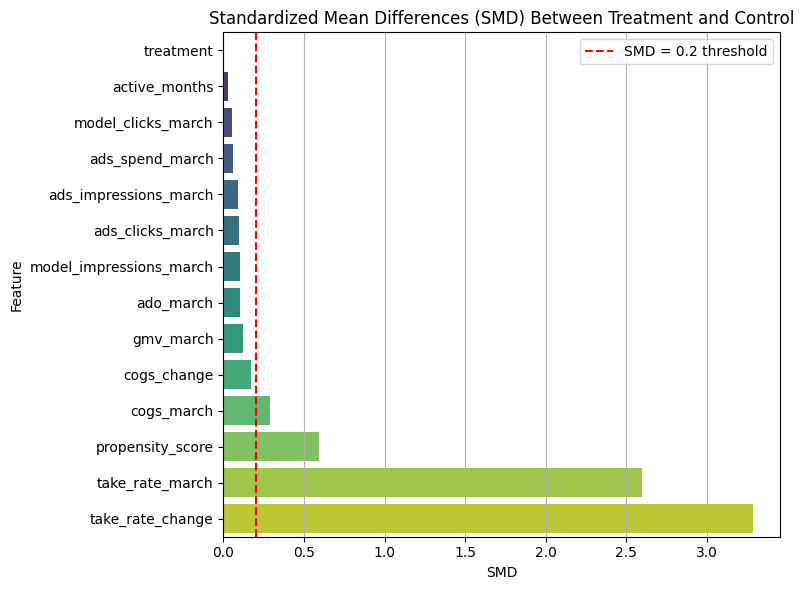

In [42]:
# Plot SMD
smd_df = compute_smd_two_groups(treatment_df, control_df, columns)
smd_df_sorted = smd_df.sort_values(by="SMD", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x="SMD", y=smd_df_sorted.index, data=smd_df_sorted, palette="viridis", hue=smd_df_sorted.index, legend=False)
plt.axvline(0.2, color="red", linestyle="--", label="SMD = 0.2 threshold")
plt.title("Standardized Mean Differences (SMD) Between Treatment and Control")
plt.xlabel("SMD")
plt.ylabel("Feature")
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

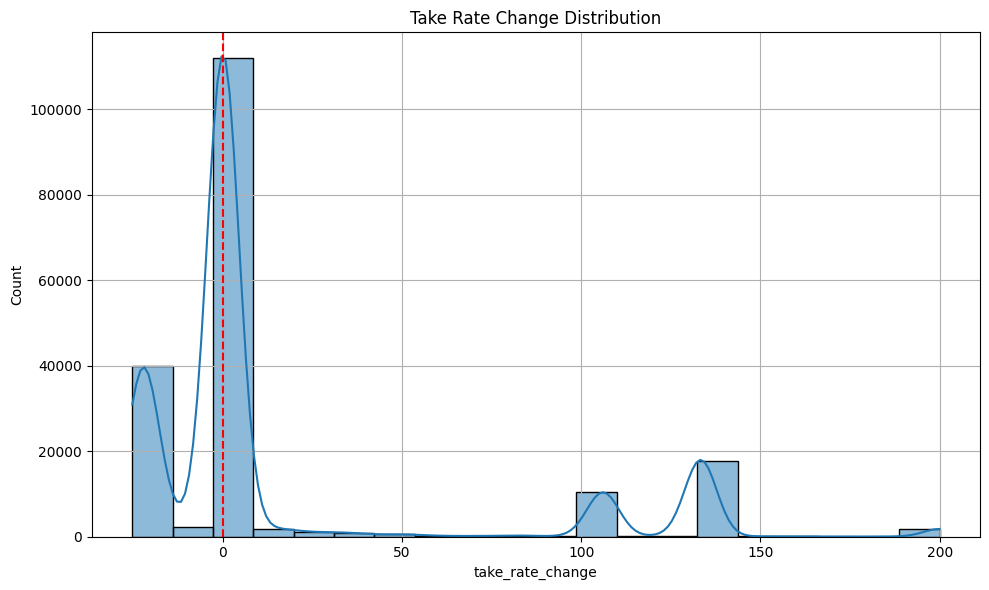

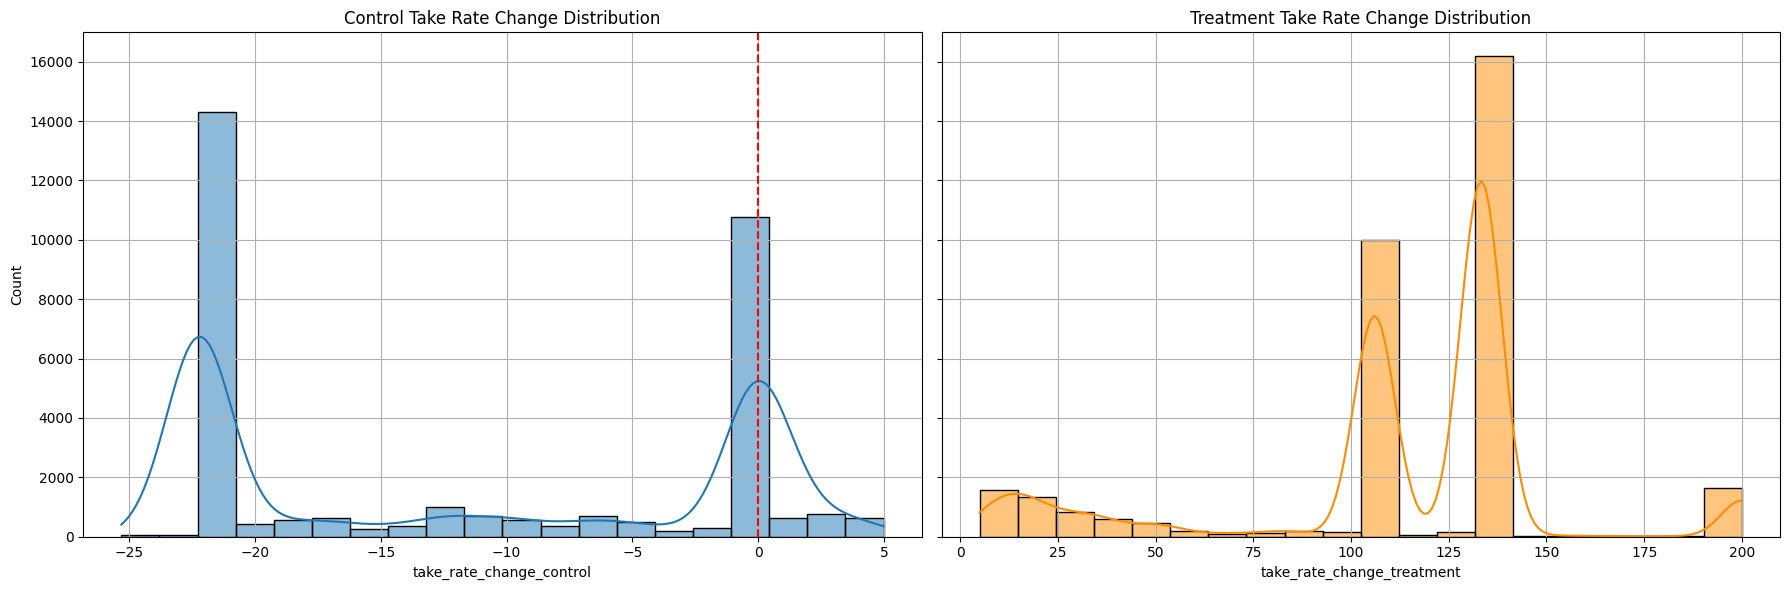

In [43]:
# Plot take rate change
plt.figure(figsize=(10, 6))
sns.histplot(tr_elha_march['take_rate_change'],kde=True,bins=20)
plt.title('Take Rate Change Distribution')
plt.grid()
plt.tight_layout()
plt.axvline(0, color='red', linestyle='--')

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(paired_stats['take_rate_change_control'], kde=True, ax=axs[0], bins=20) 
axs[0].axvline(0, color='red', linestyle='--') 
axs[0].grid()
axs[0].set_title('Control Take Rate Change Distribution')

sns.histplot(paired_stats['take_rate_change_treatment'], kde=True, ax=axs[1], color='darkorange', bins=20) 
axs[1].grid()
axs[1].set_title('Treatment Take Rate Change Distribution')

plt.tight_layout()
plt.show()

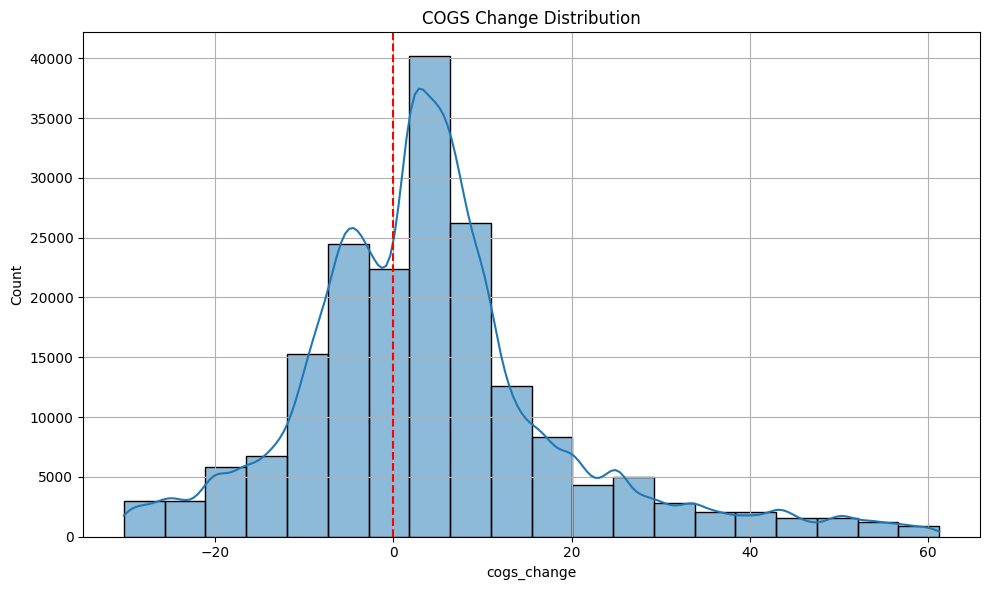

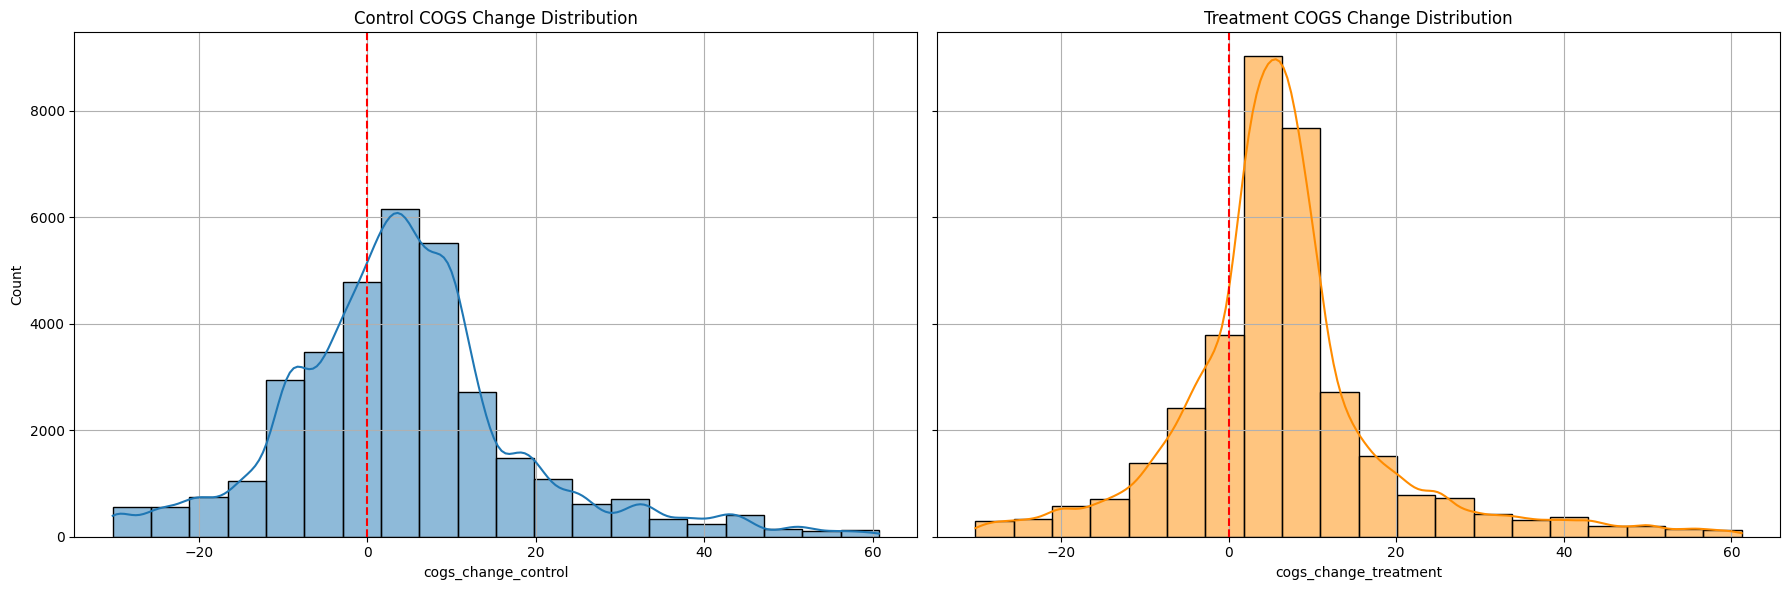

In [44]:
# COGS Change distributions
plt.figure(figsize=(10, 6))
sns.histplot(tr_elha_march['cogs_change'],kde=True,bins=20)
plt.title('COGS Change Distribution')
plt.grid()
plt.tight_layout()
plt.axvline(0, color='red', linestyle='--')

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(paired_stats['cogs_change_control'], kde=True, ax=axs[0], bins=20)
axs[0].axvline(0, color='red', linestyle='--') 
axs[0].grid()
axs[0].set_title('Control COGS Change Distribution')

sns.histplot(paired_stats['cogs_change_treatment'], kde=True, ax=axs[1], color='darkorange', bins=20)
axs[1].axvline(0, color='red', linestyle='--') 
axs[1].grid()
axs[1].set_title('Treatment COGS Change Distribution')

plt.tight_layout()
plt.show()

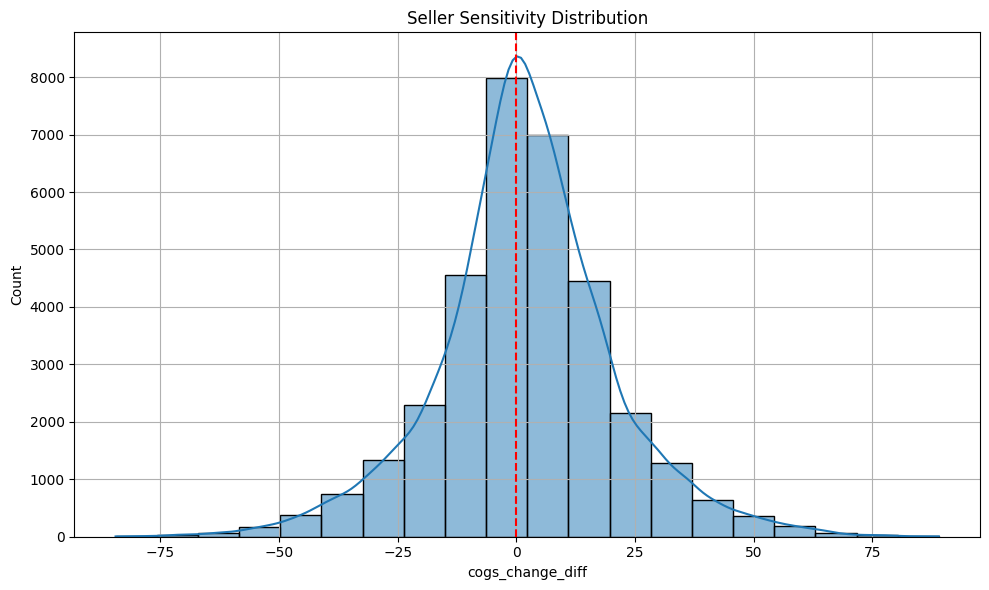

In [45]:
# Plot seller sensitivity
plt.figure(figsize=(10, 6))
sns.histplot(paired_stats['cogs_change_diff'], kde=True, bins=20)
plt.title('Seller Sensitivity Distribution')
plt.grid()
plt.tight_layout()
plt.axvline(0, color='red', linestyle='--')
plt.show()

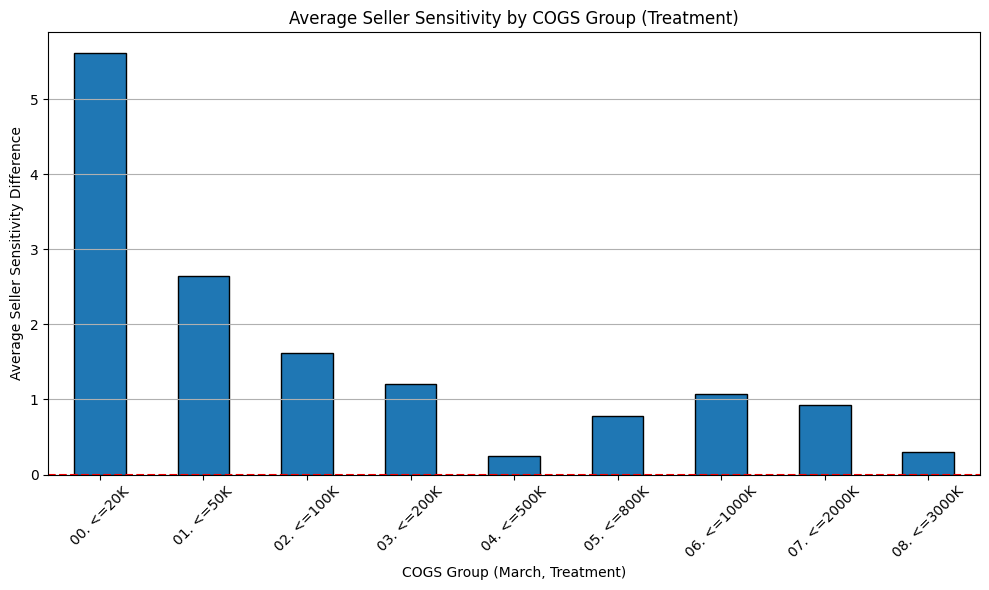

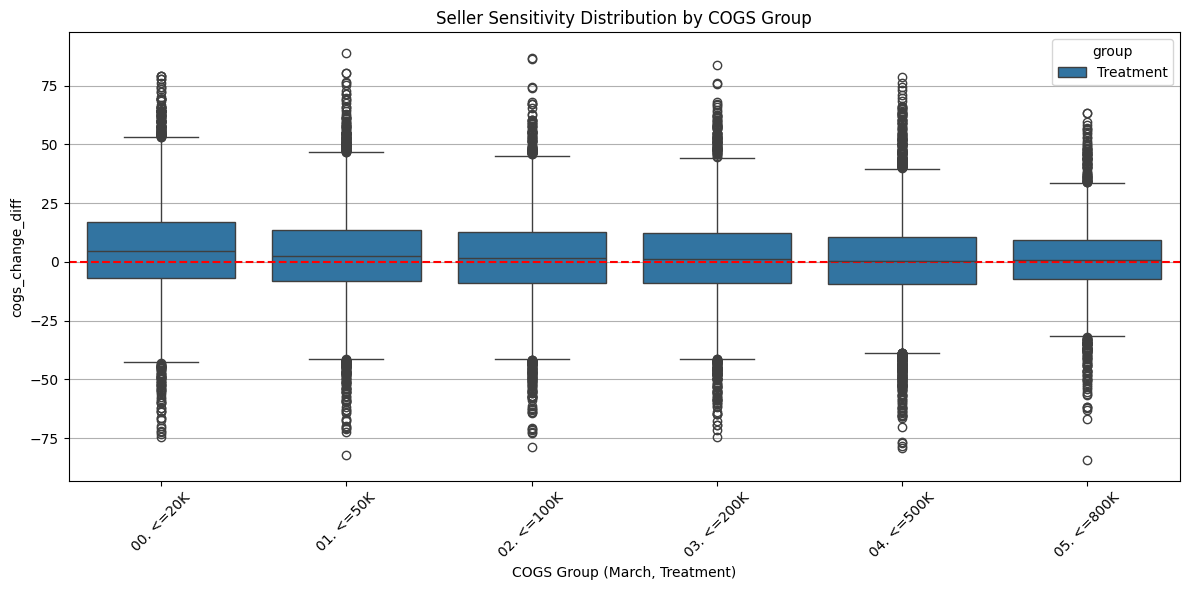

In [46]:
# Seller sensitivity by COGS group
group_means = paired_stats.groupby('cogs_group_march_treatment')['cogs_change_diff'].mean()

plt.figure(figsize=(10, 6))
group_means.plot(kind='bar', edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.title('Average Seller Sensitivity by COGS Group (Treatment)')
plt.xlabel('COGS Group (March, Treatment)')
plt.ylabel('Average Seller Sensitivity Difference')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

treatment_df = paired_stats[['cogs_group_march_treatment', 'cogs_change_diff']].rename(columns={'cogs_group_march_treatment': 'cogs_group'})
treatment_df['group'] = 'Treatment'
order = ['00. <=20K', '01. <=50K', '02. <=100K', '03. <=200K', '04. <=500K', '05. <=800K']

plt.figure(figsize=(12, 6))
sns.boxplot(data=treatment_df, x='cogs_group', y='cogs_change_diff', hue='group', order=order)
plt.axhline(0, color='red', linestyle='--')
plt.title('Seller Sensitivity Distribution by COGS Group')
plt.xlabel('COGS Group (March, Treatment)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

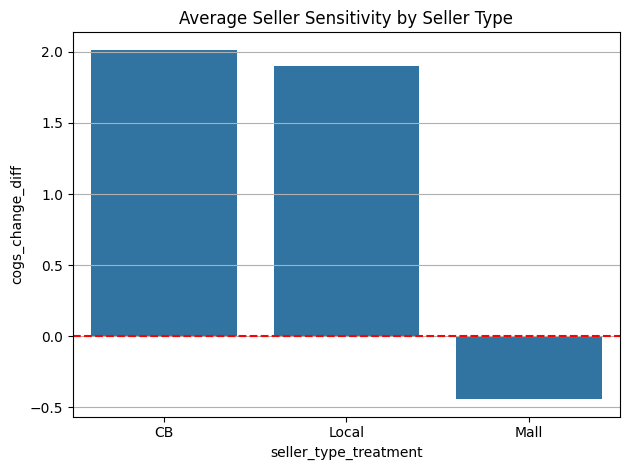

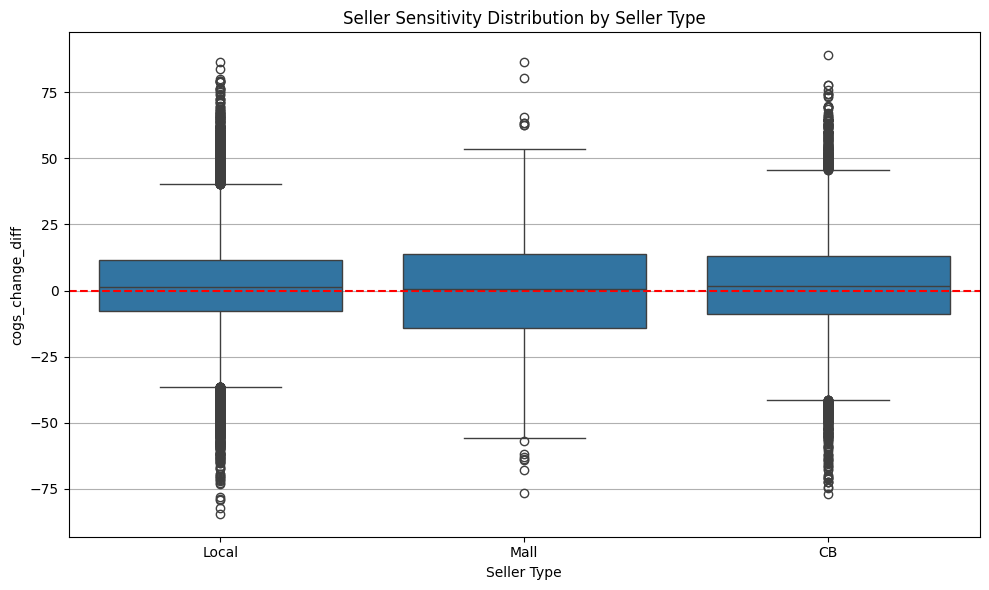

In [47]:
# Seller sensitivity by seller type
mean_effects = paired_stats.groupby('seller_type_treatment')['cogs_change_diff'].mean().reset_index()
sns.barplot(x='seller_type_treatment', y='cogs_change_diff', data=mean_effects)
plt.title('Average Seller Sensitivity by Seller Type')
plt.axhline(0, color='red', linestyle='--')
plt.grid(axis='y')
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.boxplot(data=paired_stats, x='seller_type_treatment', y='cogs_change_diff')
plt.axhline(0, color='red', linestyle='--')
plt.title('Seller Sensitivity Distribution by Seller Type')
plt.xlabel('Seller Type')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

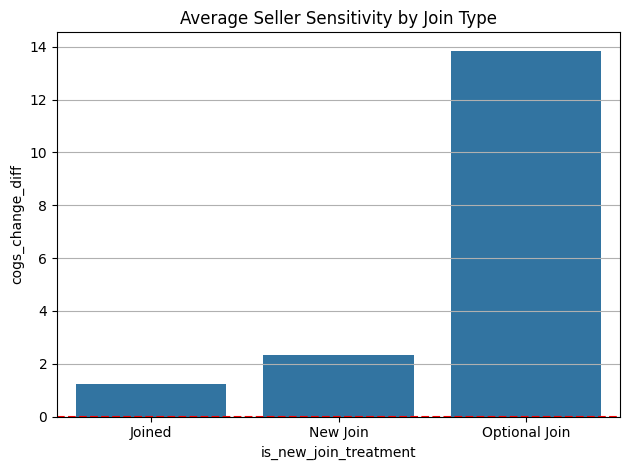

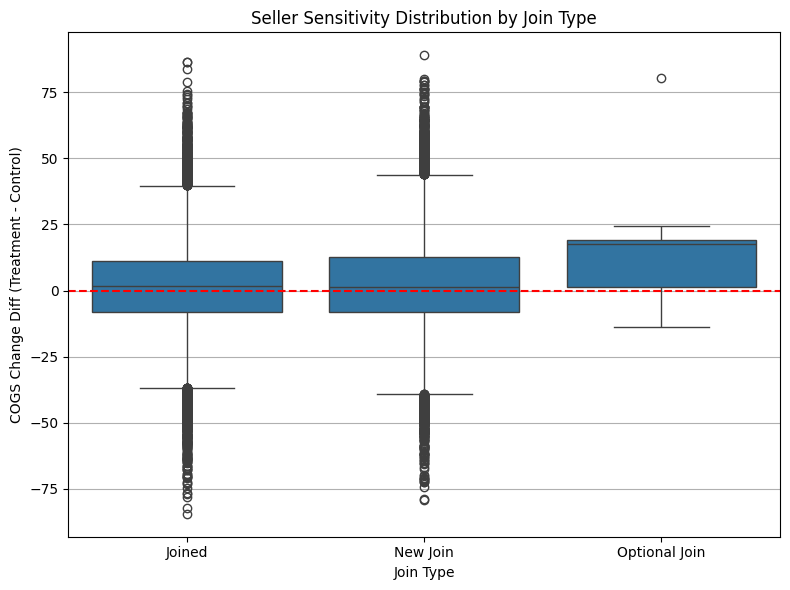

In [48]:
# Seller sensitivity by join type
mean_effects = paired_stats.groupby('is_new_join_treatment')['cogs_change_diff'].mean().reset_index()
sns.barplot(x='is_new_join_treatment', y='cogs_change_diff', data=mean_effects)
plt.title('Average Seller Sensitivity by Join Type')
plt.axhline(0, color='red', linestyle='--')
plt.grid(axis='y')
plt.tight_layout()

plt.figure(figsize=(8, 6))
sns.boxplot(data=paired_stats, x='is_new_join_treatment', y='cogs_change_diff')
plt.axhline(0, color='red', linestyle='--')
plt.title('Seller Sensitivity Distribution by Join Type')
plt.xlabel('Join Type')
plt.ylabel('COGS Change Diff (Treatment - Control)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()